In [1]:
from qiskit import *
from qiskit.providers.fake_provider import FakeManila, FakeKolkata, FakeSherbrooke
from qiskit_ibm_provider import IBMProvider

import mthree
import matplotlib.pyplot as plt 
from mthree.utils import *
from mthree.generators.random import RandomGenerator, RandomComplimentGenerator
from mthree.generators import HadamardGenerator
from mthree._helpers import system_info

from qiskit.primitives import BackendEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session, Options

from mthree.twirling.tw_calibrations import Tw_Calibration
from mthree.twirling.tw_circuits import Tw_Circuit
from mthree.twirling.tw_utils import vals_from_dict
from mthree.twirling.tw_utils import convert_to_probabilities, marginalize_calibration_counts, sort_counts

In [44]:
provider = IBMProvider()
backend = FakeManila()

In [3]:
def donothing(N):
    qc = QuantumCircuit(N, N)
    for i in range(N):
        qc.measure(i,i)
    trans_qc = transpile(qc, backend, optimization_level=3, seed_transpiler=12345)
    return trans_qc

def GHZ(N):
    qc = QuantumCircuit(N, N)
    qc.h(0)
    for i in range(1,N):
        qc.cx(0,i)
    for i in range(N):
        qc.measure(i,i)
    trans_qc = transpile(qc, backend, optimization_level=3, seed_transpiler=12345)
    return trans_qc

def m3circuit(N):
    qc = QuantumCircuit(N, N)
    qc.x(range(N))
    qc.h(range(N))

    for kk in range(N // 2, 0, -1):
        qc.ch(kk, kk - 1)
    for kk in range(N // 2, N - 1):
        qc.ch(kk, kk + 1)
    for i in range(N):
        qc.measure(i,i)
    trans_qc = transpile(qc, backend, optimization_level=3, seed_transpiler=12345)
    return trans_qc

def untranspiled_donothing(N):
    qc = QuantumCircuit(N, N)
    for i in range(N):
        qc.measure(i,i)
    return qc

def untranspiled_GHZ(N):
    qc = QuantumCircuit(N, N)
    qc.h(0)
    for i in range(1,N):
        qc.cx(0,i)
    for i in range(N):
        qc.measure(i,i)
    return qc

def untranspiled_m3circuit(N):
    qc = QuantumCircuit(N, N)
    qc.x(range(N))
    qc.h(range(N))

    for kk in range(N // 2, 0, -1):
        qc.ch(kk, kk - 1)
    for kk in range(N // 2, N - 1):
        qc.ch(kk, kk + 1)
    for i in range(N):
        qc.measure(i,i)
    return qc

def ManyParallel_uint2bits(in_intAr,Nbits):
    ''' convert (numpyarray of uint => array of Nbits bits) for many bits in parallel'''
    inSize_T= in_intAr.shape
    in_intAr_flat=in_intAr.flatten()
    out_NbitAr= np.zeros((len(in_intAr_flat),Nbits))
    for iBits in range(Nbits):
        out_NbitAr[:,iBits]= (in_intAr_flat>>iBits)&1
    out_NbitAr= out_NbitAr.reshape(inSize_T+(Nbits,))
    out_NbitAr = np.flip(out_NbitAr)
    return out_NbitAr.astype('uint8')

class CompleteGenerator:
    """Complete bit-array generator with every bit array"""

    def __init__(self, num_qubits, seed=None):
        """Generator of random arrays corresponding to random x-gates on
        qubits for TexMex mitigation

        Parameters:
            num_qubits (int): Number of qubits
            seed (int): seed for RNG, default=None

        Attributes:
            num_qubits (int): Number of qubits / length of arrays
            length (int): Total number of generated arrays, default=16
            seed (int): Seed used for RNG
        """
        self.name = "random"
        self.seed = seed
        if self.seed is None:
            self.seed = np.random.randint(0, np.iinfo(np.int32).max)
        self._RNG = np.random.default_rng(seed=self.seed)
        self.num_qubits = num_qubits
        self.length = 2**num_qubits
        self._iter_index = 0

    def __iter__(self):
        self._RNG = np.random.default_rng(seed=self.seed)
        self._iter_index = 0
        return self

    def __next__(self):
        if self._iter_index < self.length:
            self._iter_index += 1
            return ManyParallel_uint2bits(np.asarray(self._iter_index),self.num_qubits)
        else:
            raise StopIteration
        
def all_z_op(qc, num_backend_qubits):
    operator_string = list(num_backend_qubits*'I')
    for key,value in final_measurement_mapping(qc).items():
        little_endian_index = num_backend_qubits-1-value
        operator_string[little_endian_index] = 'Z'
    operator_string = "".join(operator_string)
    op = SparsePauliOp.from_list([(operator_string, 1)])
    return op

def convert_to_probabilities(counts):
    total_counts = sum(counts.values())
    probabilities = {bitstring: count / total_counts for bitstring, count in counts.items()}
    return probabilities

def total_variation_distance(counts1, counts2):
    probabilities1 = convert_to_probabilities(counts1)
    probabilities2 = convert_to_probabilities(counts2)
    all_keys = set(probabilities1.keys()).union(set(probabilities2.keys()))
    tv_distance = 0.0
    for bitstring in all_keys:
        prob1 = probabilities1.get(bitstring, 0.0)
        prob2 = probabilities2.get(bitstring, 0.0)
        tv_distance += abs(prob1 - prob2)
    return tv_distance / 2.0

In [35]:
# bit_flip_prob = 0.05  # bit flip readout

# from qiskit import Aer
# from qiskit.visualization import plot_histogram
# from qiskit_aer import AerSimulator
# import qiskit_aer.noise as noise

# # Build noise model from backend properties
# backend = FakeManila()
# noise_model = NoiseModel.from_backend(backend)
# num_backend_qubits = system_info(backend)["num_qubits"]

# # Error probabilities
# readout_probabilities = [[1-bit_flip_prob, bit_flip_prob], [bit_flip_prob, 1-bit_flip_prob]]   # measurement error 

# # Readout quantum errors
# readout_error = noise.ReadoutError(readout_probabilities)

# # Add errors to noise model
# noise_model = noise.NoiseModel()
# noise_model.add_all_qubit_readout_error(readout_error)

# # Get basis gates from noise model
# basis_gates = noise_model.basis_gates

In [45]:
N=5
qc = untranspiled_donothing(N)
#qc = untranspiled_GHZ(N)
#qc = untranspiled_m3circuit(N)

# Perform a noise simulation
backend = AerSimulator(noise_model=noise_model, basis_gates=basis_gates)
transpiled_circuit = transpile(qc, backend)
result = backend.run(transpiled_circuit, shots=2**16).result()
counts = result.get_counts()
print(expval(items=counts, exp_ops=N*'Z'))
#plot_histogram(counts)
#print(np.sqrt(2*np.log(4/0.05)/2**13))

0.594451904296875


In [46]:
measurement_map = final_measurement_mapping(transpiled_circuit)
qubits_to_calibrate = vals_from_dict(measurement_map)

groud_truth = Tw_Circuit(backend, circuit=transpiled_circuit, generator=CompleteGenerator)
groud_truth.tw_data_from_backend(shots=2**22)
groud_truth_counts = groud_truth.to_untwirled_data()
sort_counts(groud_truth_counts)

{'00000': 3245098,
 '10000': 171576,
 '00100': 170893,
 '01000': 170873,
 '00010': 170827,
 '00001': 170560,
 '00101': 9106,
 '01010': 9061,
 '10100': 9039,
 '11000': 9030,
 '00110': 9009,
 '10010': 9000,
 '10001': 8905,
 '00011': 8841,
 '01001': 8832,
 '01100': 8780,
 '01110': 517,
 '11001': 499,
 '10011': 497,
 '10110': 479,
 '11100': 478,
 '00111': 465,
 '10101': 462,
 '01101': 452,
 '11010': 450,
 '01011': 443,
 '11110': 31,
 '11011': 26,
 '10111': 25,
 '11101': 24,
 '01111': 23,
 '11111': 3}

In [52]:
trials = 100
calib_shots = 2**13

def gen_tvd(gen, gen_size):
    random_tvds = []
    gen_lengths = trials*[gen_size]
    for _ in range(trials):
        tw_circuit = Tw_Circuit(backend, circuit=transpiled_circuit, generator=gen, num_random_circuits=gen_size)
        tw_circuit.tw_data_from_backend(shots=calib_shots)
        tw_counts = tw_circuit.to_untwirled_data()
        random_tvds.append(total_variation_distance(counts1=groud_truth_counts, counts2=tw_counts))
    return [gen_lengths,random_tvds]

gen_tvd(gen=RandomGenerator, gen_size=4)[1]

[0.009861946105957031,
 0.005297183990478516,
 0.010346651077270508,
 0.00966787338256836,
 0.01589179039001465,
 0.004886627197265625,
 0.010170459747314453,
 0.008101940155029297,
 0.007367134094238281,
 0.01065826416015625,
 0.011729240417480469,
 0.010724782943725586,
 0.009551048278808594,
 0.007330894470214844,
 0.004561185836791992,
 0.01236104965209961,
 0.008724451065063477,
 0.006300210952758789,
 0.007934808731079102,
 0.006180763244628906,
 0.004816770553588867,
 0.005623340606689453,
 0.008030891418457031,
 0.008027315139770508,
 0.007973432540893555,
 0.004729509353637695,
 0.007317781448364258,
 0.008061408996582031,
 0.010637521743774414,
 0.009643793106079102,
 0.014357566833496094,
 0.015279293060302734,
 0.007862091064453125,
 0.009414911270141602,
 0.007158517837524414,
 0.009393453598022461,
 0.012130975723266602,
 0.010307788848876953,
 0.007858753204345703,
 0.010270833969116211,
 0.009415626525878906,
 0.008608102798461914,
 0.009243965148925781,
 0.009132623672

In [53]:
lengths = range(2, 64, 2)
random_x = [] 
random_y = []
compliment_x = []
compliment_y = []

for length in lengths:
    print(length)
    random_tvd_result = gen_tvd(gen=RandomGenerator, gen_size=length)
    random_x.append(random_tvd_result[0])
    random_y.append(random_tvd_result[1])

    compliment_tvd_result = gen_tvd(gen=RandomComplimentGenerator, gen_size=length)
    compliment_x.append(compliment_tvd_result[0])
    compliment_y.append(compliment_tvd_result[1])

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62


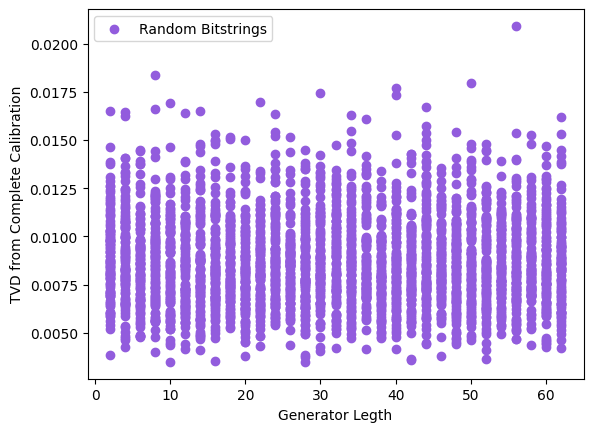

In [59]:
plt.scatter(random_x, random_y, label='Random Bitstrings', color = '#925cdd')
#plt.plot(random_x, random_y, 'o', color = '#925cdd', ms=5)
#plt.scatter(compliment_x, compliment_y, label='Random Complete Bitstrings')
plt.xlabel('Generator Legth')
plt.ylabel('TVD from Complete Calibration')
plt.legend()
plt.savefig("tvd.jpg",bbox_inches ="tight", transparent = True, orientation ='landscape')
plt.show()

In [27]:
# lengths = [2,4,8,16]
# random_tvds = [] 
# random_tvds_std= []
# compliment_tvds = []
# compliment_tvds_std = []
# # complete_tvds = []
# # complete_tvds_std = []

# for length in lengths:
#     random_tvd = gen_tvd(gen=RandomGenerator, gen_size=length)
#     random_tvds.append(np.average(random_tvd))
#     random_tvds_std.append(np.std(random_tvd))

#     compliment_tvd = gen_tvd(gen=RandomComplimentGenerator, gen_size=length)
#     compliment_tvds.append(np.average(compliment_tvd))
#     compliment_tvds_std.append(np.std(compliment_tvd))

#     # complete_tvd = gen_tvd(gen=CompleteGenerator, gen_size=length)
#     # complete_tvds.append(np.average(complete_tvd))
#     # complete_tvds_std.append(np.std(complete_tvd))

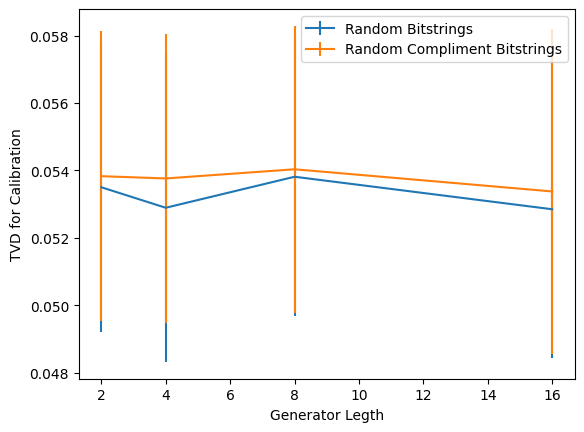

In [28]:
# plt.errorbar(lengths, random_tvds, yerr=random_tvds_std, label='Random Bitstrings')
# plt.xlabel('Generator Legth')
# plt.ylabel('TVD for Calibration')
# plt.errorbar(lengths, compliment_tvds, yerr=compliment_tvds_std, label='Random Compliment Bitstrings')
# #plt.errorbar(lengths, complete_tvds, yerr=complete_tvds_std, label='Complete Generator')
# plt.legend()
# #plt.savefig("bitstrings.svg",bbox_inches ="tight", transparent = True, orientation ='landscape')
# plt.show()